In [13]:
import pandas as pd
from pandas import read_sql_table
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [6]:
SQLALCHEMY_DATABASE_URI = 'postgresql://{db_user}:{db_password}@{db_host}:5432/{db_name}'.format(
            db_host = '34.69.215.94',
            db_name = 'snpiao_data',
            db_password = 'ucamnafinki',
            db_user = 'snpiao_data',
)

In [8]:
energy = read_sql_table('tsdb_fronius_energy',SQLALCHEMY_DATABASE_URI)
cams = read_sql_table('tsdb_cams', SQLALCHEMY_DATABASE_URI)
merra = read_sql_table('tsdb_merra', SQLALCHEMY_DATABASE_URI)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


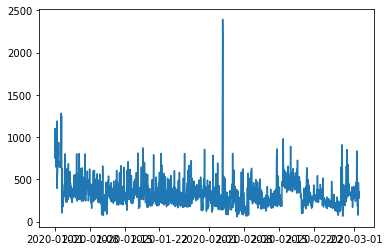

In [9]:
energy = energy.set_index('datetime').sort_index()
cams = cams.set_index('datetime').sort_index()
merra = merra.set_index('datetime').sort_index()
energy = energy.resample('1H').agg('mean')

merged = cams.merge(energy, on='datetime')
merged = merged.merge(merra, on='datetime')
merged.fillna(method='ffill', inplace=True)
merged['hour'] = merged.index.hour
merged['dayofweek'] = merged.index.dayofweek
merged['consumption'] = merged['FromGenToConsumer'] + merged['FromGridToConsumer']
pyplot.plot(merged['consumption'])

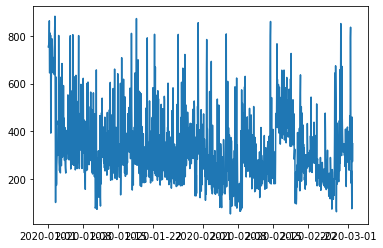

In [11]:
q = merged['consumption'].quantile(0.99)
merged = merged[merged['consumption'] < q]

pyplot.plot(merged['consumption'])
pyplot.show()

In [12]:
merged

id_x          start_time      TOA  csky_ghi  csky_bhi  \
datetime                                                                     
2020-01-01 00:00:00    40 2019-12-31 23:00:00   0.0000    0.0000     0.000   
2020-01-01 04:00:00    40 2020-01-01 03:00:00   0.0000    0.0000     0.000   
2020-01-01 05:00:00    40 2020-01-01 04:00:00   0.0000    0.0000     0.000   
2020-01-01 06:00:00    40 2020-01-01 05:00:00   0.0000    0.0000     0.000   
2020-01-01 07:00:00    40 2020-01-01 06:00:00  88.9221   48.5114    31.912   
...                   ...                 ...      ...       ...       ...   
2020-03-01 20:00:00    40 2020-03-01 19:00:00   0.0000    0.0000     0.000   
2020-03-01 21:00:00    40 2020-03-01 20:00:00   0.0000    0.0000     0.000   
2020-03-01 22:00:00    40 2020-03-01 21:00:00   0.0000    0.0000     0.000   
2020-03-01 23:00:00    40 2020-03-01 22:00:00   0.0000    0.0000     0.000   
2020-03-02 00:00:00    40 2020-03-01 23:00:00   0.0000    0.0000     0.000   

                     csky_dhi  csky_bni       gh      bhi       df  ...  \
datetime                                                            ...   
2020-01-01 00:00:00    0.0000    0.0000   0.0000   0.0000   0.0000  ...   
2020-01-01 04:00:00    0.0000    0.0000   0.0000   0.0000   0.0000  ...   
2020-01-01 05:00:00    0.0000    0.0000   0.0000   0.0000   0.0000  ...   
2020-01-01 06:00:00    0.0000    0.0000   0.0000   0.0000   0.0000  ...   
2020-01-01 07:00:00   16.5994  347.7517  43.2151  26.0007  17.2143  ...   
...                       ...       ...      ...      ...      ...  ...   
2020-03-01 20:00:00    0.0000    0.0000   0.0000   0.0000   0.0000  ...   
2020-03-01 21:00:00    0.0000    0.0000   0.0000   0.0000   0.0000  ...   
2020-03-01 22:00:00    0.0000    0.0000   0.0000   0.0000   0.0000  ...   
2020-03-01 23:00:00    0.0000    0.0000   0.0000   0.0000   0.0000  ...   
2020-03-02 00:00:00    0.0000    0.0000   0.0000   0.0000   0.0000  ...   

                       rhum  pres_hpa  wspd    wdir  rainfall  snowfall  \
datetime                                                                  
2020-01-01 00:00:00   50.91    905.63  1.51   13.94  0.001754  0.000000   
2020-01-01 04:00:00   65.06    905.38  2.37   28.62  0.000000  0.002752   
2020-01-01 05:00:00   72.50    905.68  2.29   35.55  0.000000  0.002205   
2020-01-01 06:00:00   81.69    905.90  2.34   40.58  0.000000  0.000926   
2020-01-01 07:00:00   88.32    906.16  2.53   43.04  0.000000  0.000965   
...                     ...       ...   ...     ...       ...       ...   
2020-03-01 20:00:00   98.38    897.66  2.56  194.03  0.000216  0.000000   
2020-03-01 21:00:00  102.63    897.35  2.60  192.75  0.001415  0.000000   
2020-03-01 22:00:00  103.84    897.10  2.70  196.24  0.005093  0.000000   
2020-03-01 23:00:00  103.66    896.87  2.85  204.28  0.009540  0.000000   
2020-03-02 00:00:00  103.32    896.60  3.04  210.49  0.023700  0.000000   

                      snowd_m  hour  dayofweek  consumption  
datetime                                                     
2020-01-01 00:00:00  0.000000     0          2   753.583333  
2020-01-01 04:00:00  0.000000     4          2   771.250000  
2020-01-01 05:00:00  0.000000     5          2   862.500000  
2020-01-01 06:00:00  0.000000     6          2   644.951667  
2020-01-01 07:00:00  0.000000     7          2   646.215000  
...                       ...   ...        ...          ...  
2020-03-01 20:00:00  0.000925    20          6    76.916667  
2020-03-01 21:00:00  0.000925    21          6   460.083333  
2020-03-01 22:00:00  0.000925    22          6   357.500000  
2020-03-01 23:00:00  0.000925    23          6   274.250000  
2020-03-02 00:00:00  0.000925     0          0   348.500000  

[1450 rows x 31 columns]

In [14]:
profile = ProfileReport(merged, title="Pandas Profiling Report")

In [15]:
profile

In [21]:
X = pd.DataFrame(data=merged, columns=['gh', 'csky_ghi', 'tdry', 'wspd', 'wdir' 'pres_hpa', 'rhum', 'snowd_m', 'rainfall'])
y = pd.DataFrame(data=merged, columns=['consumption'])
to_csv = pd.DataFrame(data = merged, columns=['gh', 'csky_ghi', 'tdry', 'wspd', 'pres_hpa', 'rhum', 'snowd_m', 'rainfall', 'consumption'])

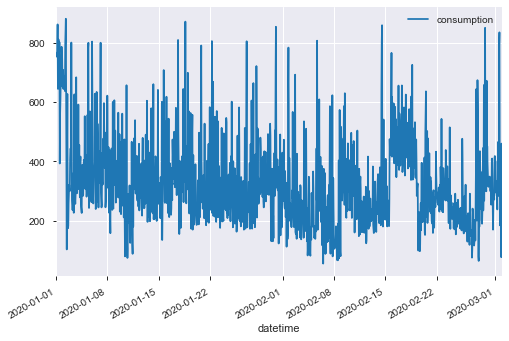

In [17]:
y.plot()

In [22]:
to_csv

gh  csky_ghi  tdry  wspd  pres_hpa    rhum  \
datetime                                                               
2020-01-01 00:00:00   0.0000    0.0000 -0.84  1.51    905.63   50.91   
2020-01-01 04:00:00   0.0000    0.0000 -3.22  2.37    905.38   65.06   
2020-01-01 05:00:00   0.0000    0.0000 -4.01  2.29    905.68   72.50   
2020-01-01 06:00:00   0.0000    0.0000 -5.10  2.34    905.90   81.69   
2020-01-01 07:00:00  43.2151   48.5114 -5.58  2.53    906.16   88.32   
...                      ...       ...   ...   ...       ...     ...   
2020-03-01 20:00:00   0.0000    0.0000  2.56  2.56    897.66   98.38   
2020-03-01 21:00:00   0.0000    0.0000  1.91  2.60    897.35  102.63   
2020-03-01 22:00:00   0.0000    0.0000  1.78  2.70    897.10  103.84   
2020-03-01 23:00:00   0.0000    0.0000  1.87  2.85    896.87  103.66   
2020-03-02 00:00:00   0.0000    0.0000  2.05  3.04    896.60  103.32   

                      snowd_m  rainfall  consumption  
datetime                                              
2020-01-01 00:00:00  0.000000  0.001754   753.583333  
2020-01-01 04:00:00  0.000000  0.000000   771.250000  
2020-01-01 05:00:00  0.000000  0.000000   862.500000  
2020-01-01 06:00:00  0.000000  0.000000   644.951667  
2020-01-01 07:00:00  0.000000  0.000000   646.215000  
...                       ...       ...          ...  
2020-03-01 20:00:00  0.000925  0.000216    76.916667  
2020-03-01 21:00:00  0.000925  0.001415   460.083333  
2020-03-01 22:00:00  0.000925  0.005093   357.500000  
2020-03-01 23:00:00  0.000925  0.009540   274.250000  
2020-03-02 00:00:00  0.000925  0.023700   348.500000  

[1450 rows x 9 columns]